In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import codecs
from tabulate import tabulate
import re
import string
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from num2words import num2words

nltk.download('words')
nltk.download('punkt')

from sklearn.model_selection import train_test_split
import numpy as np
import random
from datasets import Dataset, DatasetDict

import spacy

import torchtext
import torch
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
e:\TU\SoSe24\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Task 1: Data exploration and Sampling

In [6]:
# Function to read text files safely
def read_text_file(file_path):
    with codecs.open(file_path, 'r', encoding='utf-8') as file:
        sentences = file.readlines()
    return sentences

# Function to calculate most frequent word
def most_frequent_word(text):
    words = text.split()
    word_freq = Counter(words)
    return word_freq.most_common(1)[0][0]

# Function to calculate unique words count
def count_unique_words(text):
    words = text.split()
    return len(set(words))

# Function to calculate numeral frequencies
def count_numerals(text):
    numeral_count = Counter(char for char in text if char.isdigit())
    return numeral_count

# File paths
en_file_path = 'de-en/europarl-v7.de-en.en'  # English language file
de_file_path = 'de-en/europarl-v7.de-en.de'  # German language file

# Read the files
en_sentences = read_text_file(en_file_path)
de_sentences = read_text_file(de_file_path)

# Create a DataFrame
df = pd.DataFrame({'en': en_sentences, 'de': de_sentences})

## Stats

In [7]:
# Basic statistics
num_sentences = len(df)
en_lengths = df['en'].str.len()
de_lengths = df['de'].str.len()
length_diff = en_lengths - de_lengths

# Calculate total number of words, unique words, and average word length
def calculate_word_stats(text):
    words = text.split()
    num_words = len(words)
    unique_words = count_unique_words(text)
    avg_word_length = sum(len(word) for word in words) / num_words
    return num_words, unique_words, avg_word_length

en_num_words, unique_en_words, awl_en = calculate_word_stats(' '.join(df['en']))
de_num_words, unique_de_words, awl_de = calculate_word_stats(' '.join(df['de']))

# Calculate most frequent words
most_freq_word_en = most_frequent_word(' '.join(df['en']))
most_freq_word_de = most_frequent_word(' '.join(df['de']))

# Calculate numeral frequencies
numeral_freq_en = count_numerals(' '.join(df['en']))
numeral_freq_de = count_numerals(' '.join(df['de']))

# Summary statistics
summary_stats = [
    ['Number of sentences', num_sentences],
    ['Total words (English)', en_num_words],
    ['Total words (German)', de_num_words],
    ['Unique words (English)', unique_en_words],
    ['Unique words (German)', unique_de_words],
    ['Average word length (English)', awl_en],
    ['Average word length (German)', awl_de],
    ['Average sentence length (English)', en_lengths.mean()],
    ['Average sentence length (German)', de_lengths.mean()],
    ['Average sentence length difference (English - German)', length_diff.mean()],
    ['Most frequent word (English)', most_freq_word_en],
    ['Most frequent word (German)', most_freq_word_de]
    #['Numerals frequency (English)', numeral_freq_en],
    #['Numerals frequency (German)', numeral_freq_de]
]

# Print summary statistics
print(tabulate(summary_stats, headers=['Statistic', 'Value'], tablefmt='pretty'))

## Display word clouds

In [ ]:
# Generate and display word clouds
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Create word clouds for English and German text
generate_word_cloud(' '.join(df['en']), 'Most Common Words in English')
generate_word_cloud(' '.join(df['de']), 'Most Common Words in German')

## Distribution of Average Word Length

In [ ]:
df['en_sentence_length'] = df['en'].str.len()
df['de_sentence_length'] = df['de'].str.len()

df['en_num_words'] = df['en'].str.split().apply(len)
df['de_num_words'] = df['de'].str.split().apply(len)

df['en_avg_word_length'] = df['en_sentence_length'] / df['en_num_words']
df['de_avg_word_length'] = df['de_sentence_length'] / df['de_num_words']

# Plotting with Seaborn
plt.figure(figsize=(4, 4))

# Distribution of Average Word Length
plt.subplot(1, 1, 1)
sns.histplot(df['en_avg_word_length'], kde=True, color='blue', label='English')
sns.histplot(df['de_avg_word_length'], kde=True, color='green', label='German')
plt.title('Distribution of Average Word Length')
plt.xlabel('Average Word Length (Characters)')
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


# Task 2: Pre-processing

In [ ]:
# Randomly select 10% of the data
df_sampled = df.sample(frac=0.10, random_state=42)

# Preprocessing steps
def preprocess_text(df, column, lang, replacements):
    df[column] = df[column].str.lower()
    df[column] = df[column].apply(remove_number_lists)
    df[column] = df[column].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    df[column] = df[column].apply(remove_specific_characters, args=(replacements,))
    df[column] = df[column].apply(remove_whitespace_before_numbers)
    df[column] = df[column].apply(remove_report_number)
    df[column] = df[column].apply(lambda x: ' '.join(x.split()))
    df[column] = df[column].apply(convert_numbers_to_words, args=(lang,))
    return df

def remove_number_lists(text):
    pattern = r'\b\d+(?:,\s*\d+)*\b'
    return re.sub(pattern, '', text).strip()

def remove_specific_characters(text, replacements):
    for key, value in replacements.items():
        text = text.replace(key, value)
    text = re.sub(r'[-„“‟”–…‘’´­•—‚‘υπέρœ―]', '', text)
    return ' '.join(text.split())

def remove_whitespace_before_numbers(text):
    return re.sub(r'(\d)\s+(\d)', r'\1\2', text)

def remove_report_number(text):
    text = re.sub(r'\b[a-z]\d+\b', '', text)
    return ' '.join(text.split())

def convert_numbers_to_words(sentence, lang='en'):
    words = word_tokenize(sentence)
    converted_words = []
    for word in words:
        try:
            number = int(word)
            if 0 <= number <= 999999999:
                converted_words.append(num2words(number, lang=lang))
            else:
                converted_words.append(word)
        except (ValueError, NotImplementedError):
            converted_words.append(word)
    return ' '.join(converted_words)

def write_files(df):
    columns_to_save = {'en': 'en.txt', 'de': 'de.txt'}
    for column, filename in columns_to_save.items():
        df[column].to_csv(filename, index=False, header=False, encoding='utf-8')
    print("Columns have been saved to separate files.")

# Define replacements for 'en' and 'de'
replacements = {
    'en': {'½': 'one half', '¾': 'three quarters', '£': 'pound', '°': 'degree', '§': 'section'},
    'de': {'½': 'ein halb', '¾': 'drei viertel', '€': 'euro', '°': 'grad', '§': 'abschnitt'}
}

# Apply preprocessing to 'en' and 'de' columns
df_sampled = preprocess_text(df_sampled, 'en', 'en', replacements['en'])
df_sampled = preprocess_text(df_sampled, 'de', 'de', replacements['de'])

# Strip empty lines and their correspondences
df_sampled = df_sampled[(df_sampled['en'].str.strip() != '') & (df_sampled['de'].str.strip() != '')]

# Write the processed data to files
write_files(df_sampled)

# Task 3: Neural Machine Translation

## Load 10 % of data

In [4]:
# Read and preprocess data
with open("de.txt", 'r', encoding='utf-8') as file1: 
    de_texts = [line.strip() for line in file1]
with open("en.txt", 'r', encoding='utf-8') as file2: 
    en_texts = [line.strip() for line in file2]

# Create a DataFrame from the lists
df_sampled = pd.DataFrame({'de': de_texts, 'en': en_texts})
df_sampled = df_sampled.sample(frac=0.05, random_state=1).reset_index(drop=True)
df_sampled.tail()
print(df_sampled.head())

                                                  de  \
0  rückwürfe von bis zu zwei millionen tonnen ges...   
1  ferner zeigt sie nützliche marktinstrumente zu...   
2  dies bringt jedoch auch höhere kosten für die ...   
3            bedeutende reaktionsfähigkeit potenzial   
4  ein tätigwerden auf dem gebiet der vermarktung...   

                                                  en  
0  discarding nearly two million tonnes of health...  
1  they can also point out useful market instrume...  
2   however it will mean more costs for the consumer  
3                   significant reactivity potential  
4  the need for action on the marketing of constr...  


## Split data. 20% test and rest into train and val split

In [5]:
test_size = 0.2  # 20% for test set
train_val_df, test_df = train_test_split(df_sampled, test_size=test_size, random_state=42)

# Further split train/validation:
val_size = 0.08  # 8% of remaining data for validation
train_df, val_df = train_test_split(train_val_df, test_size=val_size, random_state=42)

print("Train data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)
print("Test data shape:", test_df.shape)

train_df.head()

Train data shape: (7006, 2)
Validation data shape: (610, 2)
Test data shape: (1904, 2)


,de,en
4997,wir werden ab mai eine gemeinschaft mit millio...,from the first of may we shall be a community ...
5944,bericht von frau maría rodríguez ramos im name...,report by maría rodríguez ramos on behalf of t...
9334,für das europäische projekt von morgen sind wi...,for the european project of the future we are ...
2102,schriftlich sv der bericht über die gemeinsame...,in writing sv the report on the common agricul...
7075,frauen und mädchen werden unterdrückt insbeson...,women and girls suffer oppression particularly...


## Create DatasetDict from train_df, val_df and test_df

In [6]:
# Convert DataFrames to Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Print the DatasetDict
print(dataset)

train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)


DatasetDict({
    train: Dataset({
        features: ['de', 'en', '__index_level_0__'],
        num_rows: 7006
    })
    validation: Dataset({
        features: ['de', 'en', '__index_level_0__'],
        num_rows: 610
    })
    test: Dataset({
        features: ['de', 'en', '__index_level_0__'],
        num_rows: 1904
    })
})


In [6]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download de_core_news_sm

## Load tokenizers

In [7]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

## Tokenize train, val and test data sets

In [8]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

max_length = 1000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map: 100%|██████████| 1904/1904 [00:00<00:00, 3026.41 examples/s]


In [9]:
train_data[1]

{'de': 'bericht von frau maría rodríguez ramos im namen des ausschusses für landwirtschaft und ländliche entwicklung über die multifunktionalität der landwirtschaft und die reform der gemeinsamen agrarpolitik ini',
 'en': 'report by maría rodríguez ramos on behalf of the committee on agriculture and rural development on multifunctional agriculture and the reform of the cap ini',
 '__index_level_0__': 5944,
 'en_tokens': ['<sos>',
  'report',
  'by',
  'maría',
  'rodríguez',
  'ramos',
  'on',
  'behalf',
  'of',
  'the',
  'committee',
  'on',
  'agriculture',
  'and',
  'rural',
  'development',
  'on',
  'multifunctional',
  'agriculture',
  'and',
  'the',
  'reform',
  'of',
  'the',
  'cap',
  'ini',
  '<eos>'],
 'de_tokens': ['<sos>',
  'bericht',
  'von',
  'frau',
  'maría',
  'rodríguez',
  'ramos',
  'im',
  'namen',
  'des',
  'ausschusses',
  'für',
  'landwirtschaft',
  'und',
  'ländliche',
  'entwicklung',
  'über',
  'die',
  'multifunktionalität',
  'der',
  'landwirt

## Create vocabularies with words and special tokens

In [10]:
min_freq = 3 # for a word to appear
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

# Tokens ONLY from train set
all_en_tokens = train_data["en_tokens"]
all_de_tokens = train_data["de_tokens"]

# Build vocabularies
en_vocab = torchtext.vocab.build_vocab_from_iterator(
    all_en_tokens,
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = torchtext.vocab.build_vocab_from_iterator(
    all_de_tokens,
    min_freq=min_freq,
    specials=special_tokens,
)

## Get indices of special tokens and set return index for non existing word in our vocabulary

In [11]:
unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)
x = 8

de_vocab.get_itos()[:x], en_vocab.get_itos()[:x]

(['<unk>', '<pad>', '<sos>', '<eos>', 'die', 'der', 'und', 'in'],
 ['<unk>', '<pad>', '<sos>', '<eos>', 'the', 'of', 'to', 'and'])

In [12]:
type(de_vocab), len(en_vocab), len(de_vocab)

(torchtext.vocab.vocab.Vocab, 4437, 5335)

## word2index

In [13]:
def numericalize_example(example, en_vocab, de_vocab):
    # Convert token lists to their corresponding indices
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

# Dictionary of keyword arguments for the function
fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

# Apply the numericalization function to each split of the dataset
train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map: 100%|██████████| 1904/1904 [00:00<00:00, 5357.47 examples/s]


In [14]:
type(train_data), train_data[1]

(datasets.arrow_dataset.Dataset,
 {'de': 'bericht von frau maría rodríguez ramos im namen des ausschusses für landwirtschaft und ländliche entwicklung über die multifunktionalität der landwirtschaft und die reform der gemeinsamen agrarpolitik ini',
  'en': 'report by maría rodríguez ramos on behalf of the committee on agriculture and rural development on multifunctional agriculture and the reform of the cap ini',
  '__index_level_0__': 5944,
  'en_tokens': ['<sos>',
   'report',
   'by',
   'maría',
   'rodríguez',
   'ramos',
   'on',
   'behalf',
   'of',
   'the',
   'committee',
   'on',
   'agriculture',
   'and',
   'rural',
   'development',
   'on',
   'multifunctional',
   'agriculture',
   'and',
   'the',
   'reform',
   'of',
   'the',
   'cap',
   'ini',
   '<eos>'],
  'de_tokens': ['<sos>',
   'bericht',
   'von',
   'frau',
   'maría',
   'rodríguez',
   'ramos',
   'im',
   'namen',
   'des',
   'ausschusses',
   'für',
   'landwirtschaft',
   'und',
   'ländliche',
   

## Indices of words as torch tensor

In [15]:
# Covert ids to torch tensors
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

## Padding

In [16]:
# Padding
# All the German sentences will have length x and all the English sentences will have length y in each batch
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch

    return collate_fn

## DataLoaders with collate_fn function

In [17]:
# Will give DataLoaders based on provided dataset
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

## Crate data loaders

In [18]:
batch_size = 64

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index, shuffle=False)
test_data_loader = get_data_loader(test_data, batch_size, pad_index, shuffle=False)

## RNN based seq2seq architecture

In [19]:
# Simple Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wa = nn.Linear(hidden_dim, hidden_dim)
        self.Ua = nn.Linear(hidden_dim, hidden_dim)
        self.Va = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [batch size, hidden dim]
        # encoder_outputs: [src len, batch size, hidden dim]

        # Repeat hidden state src_len times
        src_len = encoder_outputs.shape[0]
        hidden = hidden[-1].unsqueeze(1).repeat(1, src_len, 1)  # [batch size, src len, hidden dim]

        # Compute energy scores
        energy = torch.tanh(self.Wa(hidden) + self.Ua(encoder_outputs.permute(1, 0, 2)))  # [batch size, src len, hidden dim]
        scores = self.Va(energy).squeeze(2)  # [batch size, src len]

        # Compute attention weights
        attn_weights = torch.softmax(scores, dim=1)  # [batch size, src len]

        # Compute context vector as weighted sum of encoder outputs
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # [batch size, src len, hidden dim]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # [batch size, hidden dim]

        return context, attn_weights


class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # [src len, batch size, embedding dim]
        outputs, (hidden, cell) = self.rnn(embedded)  # outputs: [src len, batch size, hidden dim]
        return outputs, hidden, cell
    
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, n_layers, dropout=dropout, batch_first=False)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hidden_dim)

    def forward(self, input, hidden, cell, encoder_outputs):
        input = input.unsqueeze(0)  # [1, batch size]
        embedded = self.dropout(self.embedding(input))  # [1, batch size, embedding dim]

        # Compute attention context vector
        context, attn_weights = self.attention(hidden, encoder_outputs)  # context: [batch size, hidden dim]

        # Concatenate embedded input with context
        rnn_input = torch.cat((embedded, context.unsqueeze(0)), dim=2)  # [1, batch size, embedding dim + hidden dim]

        # Pass input through RNN
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))  # output: [1, batch size, hidden dim]

        # Pass through fully connected layer
        prediction = self.fc_out(output.squeeze(0))  # [batch size, output dim]

        return prediction, hidden, cell, attn_weights

    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden, cell = self.encoder(src)

        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

## Set parameters

In [20]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)

encoder_embedding_dim = 300
decoder_embedding_dim = 300
hidden_dim = 256
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

## Train and evaluation loops

In [21]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(tqdm(data_loader)):
        src = batch["de_ids"].to(device)
        trg = batch["en_ids"].to(device)

        optimizer.zero_grad()
        
        output = model(src, trg, teacher_forcing_ratio)

        output_dim = output.shape[-1]

        output = output[1:].view(-1, output_dim)

        trg = trg[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(tqdm(data_loader)):
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)

            output = model(src, trg, 0)

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)

            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(data_loader)

## Load GloVe Embedding Matrices. Train with GloVe embeddings. Evaluate with GloVe embeddings.

### Load embeddings

In [22]:
os.makedirs("embeddings", exist_ok=True)
import torch
from torchtext.vocab import Vocab

# Create glove embedding matrices
def load_glove_embeddings(glove_file, vocab: Vocab, embedding_dim: int):
    # Initialize the embedding matrix with small random values using PyTorch
    embedding_matrix = torch.randn((len(vocab), embedding_dim)) * 0.01
    
    # Load pre-trained GloVe embeddings
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            if word in vocab:  # Check if the word is in the vocabulary
                idx = vocab.get_stoi()[word]
                embedding_vector = torch.tensor([float(val) for val in parts[1:]], dtype=torch.float32)
                embedding_matrix[idx] = embedding_vector
    
    # Initialize special token embeddings
    # 0: '<unk>', 1: '<pad>', 2: '<sos>', 3: '<eos>'
    embedding_matrix[0] = torch.randn(embedding_dim) * 0.1  # Small random values for unknown
    embedding_matrix[1] = torch.zeros(embedding_dim)  # Zero initialization for padding token
    embedding_matrix[2] = torch.randn(embedding_dim) * 0.1  # Small random values (sos)
    embedding_matrix[3] = torch.randn(embedding_dim) * 0.1  # Small random values (eos)
    
    return embedding_matrix

embedding_dim = 300
en_glove_file = 'glove.6B.300d.txt'
de_glove_file = 'glove.de.txt' # https://www.deepset.ai/german-word-embeddings

# en_gembedding_matrix = load_glove_embeddings(en_glove_file, en_vocab, embedding_dim)
# de_gembedding_matrix = load_glove_embeddings(de_glove_file, de_vocab, embedding_dim)

# Save the embedding matrices
# torch.save(en_gembedding_matrix, 'embeddings/en_gembedding_matrix.pt')
# torch.save(de_gembedding_matrix, 'embeddings/de_gembedding_matrix.pt')

# Load the embedding matrices
en_gembedding_matrix = torch.load('embeddings/en_gembedding_matrix.pt')
de_gembedding_matrix = torch.load('embeddings/de_gembedding_matrix.pt')

### Train German to English model with GloVe embeddings

In [23]:
os.makedirs("models", exist_ok=True)

import gc
gc.collect()
torch.cuda.empty_cache()

model = Seq2Seq(encoder, decoder, device).to(device)

# Load our preptrained GloVe embeddings
encoder.embedding.weight.data.copy_(de_gembedding_matrix)
decoder.embedding.weight.data.copy_(en_gembedding_matrix)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)


n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
best_valid_loss = float("inf")

for epoch in range(n_epochs):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "models/word_model_glove_de_en_attention.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")
    print(f"Batch {epoch+1} done \n")

### Evaluate German to English with BLEU and ROUGH scores with GloVe embeddings.

In [24]:
model.load_state_dict(torch.load("models/word_model_glove_de_en_attention.pt"))
test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

100%|██████████| 30/30 [00:05<00:00,  5.35it/s]

| Test Loss: 5.760 | Test PPL: 317.302 |


In [25]:
import evaluate
# Load BLEU metric
bleu = evaluate.load("bleu")

def translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        if lower:
            tokens = [token.lower() for token in tokens]
        tokens = [sos_token] + tokens + [eos_token]
        ids = de_vocab.lookup_indices(tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        outputs, hidden, cell = model.encoder(tensor)

        inputs = en_vocab.lookup_indices([sos_token])
        all_attention_weights = []  # Collect attention weights for each step

        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, cell, attention_weights = model.decoder(inputs_tensor, hidden, cell, outputs)
            all_attention_weights.append(attention_weights.cpu().numpy())  # Store attention weights
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)

            if predicted_token == en_vocab[eos_token]:
                break
        tokens = en_vocab.lookup_tokens(inputs)
    return tokens, all_attention_weights

In [26]:
sentence = test_data[0]["de"]
expected_translation = test_data[0]["en"]

sentence, expected_translation

('diese mission erscheint mir als besonders zweckmäßig da die europäische union der wichtigste partner sowohl in bezug auf die entwicklungshilfe als auch auf die wirtschaftliche zusammenarbeit und gleichzeitig der hauptinvestor in peru ist',
 'this mission seems to me to be particularly appropriate since the european union is the main provider of development aid and economic cooperation and it is also the main investor in peru')

In [27]:
translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

translation[0]

['<sos>',
 'the',
 'the',
 'of',
 'the',
 'the',
 'of',
 'the',
 'the',
 '<unk>',
 'of',
 'the',
 'the',
 'the',
 'the',
 'the',
 '<unk>',
 'of',
 'the',
 '<unk>',
 'of',
 'the',
 '<unk>',
 'of',
 'the',
 '<unk>']

In [28]:
import evaluate
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Updated function to translate sentences from English to German and return attention weights
translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token,
        device
    )
    for example in tqdm(test_data)
]

100%|██████████| 1904/1904 [01:01<00:00, 30.74it/s]


In [29]:
bleu = evaluate.load("bleu")

In [30]:
# Format the predictions and attention weights for BLEU evaluation
predictions = [" ".join(translation[0][1:-1]) for translation in translations]  # Translation without <sos> and <eos>
references = [[example["en"]] for example in test_data]  # List of references for BLEU evaluation

In [31]:
predictions[7], references[7]

('the is not to the the the of the <unk> of the <unk> of the',
 ['some people do not like you because you are too european and others because of ideological prejudice'])

In [32]:
# Function to get the tokenizer
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        # Split the text by spaces first to handle special tokens
        tokens = s.split()
        # Process each token using the NLP tokenizer, except for special tokens
        processed_tokens = []
        for token in tokens:
            if token == "<unk>" or "<sos>" or "<eos>":
                processed_tokens.append(token)
            else:
                processed_tokens.extend([tok.text for tok in nlp.tokenizer(token)])
        # Convert to lowercase if required
        if lower:
            processed_tokens = [token.lower() for token in processed_tokens]
        return processed_tokens
    return tokenizer_fn

# Get the tokenizer function
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [33]:
tokenizer_fn(predictions[0]), tokenizer_fn(references[0][0])

(['the',
  'the',
  'of',
  'the',
  'the',
  'of',
  'the',
  'the',
  '<unk>',
  'of',
  'the',
  'the',
  'the',
  'the',
  'the',
  '<unk>',
  'of',
  'the',
  '<unk>',
  'of',
  'the',
  '<unk>',
  'of',
  'the'],
 ['this',
  'mission',
  'seems',
  'to',
  'me',
  'to',
  'be',
  'particularly',
  'appropriate',
  'since',
  'the',
  'european',
  'union',
  'is',
  'the',
  'main',
  'provider',
  'of',
  'development',
  'aid',
  'and',
  'economic',
  'cooperation',
  'and',
  'it',
  'is',
  'also',
  'the',
  'main',
  'investor',
  'in',
  'peru'])

In [34]:
source = test_data[2]["de"]

prediction, attention_weights = translate_sentence(
    source,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [35]:
source_tokens = [token.text for token in en_nlp(source)]
predicted_tokens = prediction[1:-1]#[token for token in prediction]

In [36]:
# Assuming attention_weights is a list of attention arrays for each target token
attention_matrix = np.squeeze(attention_weights, axis=1)  # Shape: [target, source]
attention_matrix.shape

(10, 11)

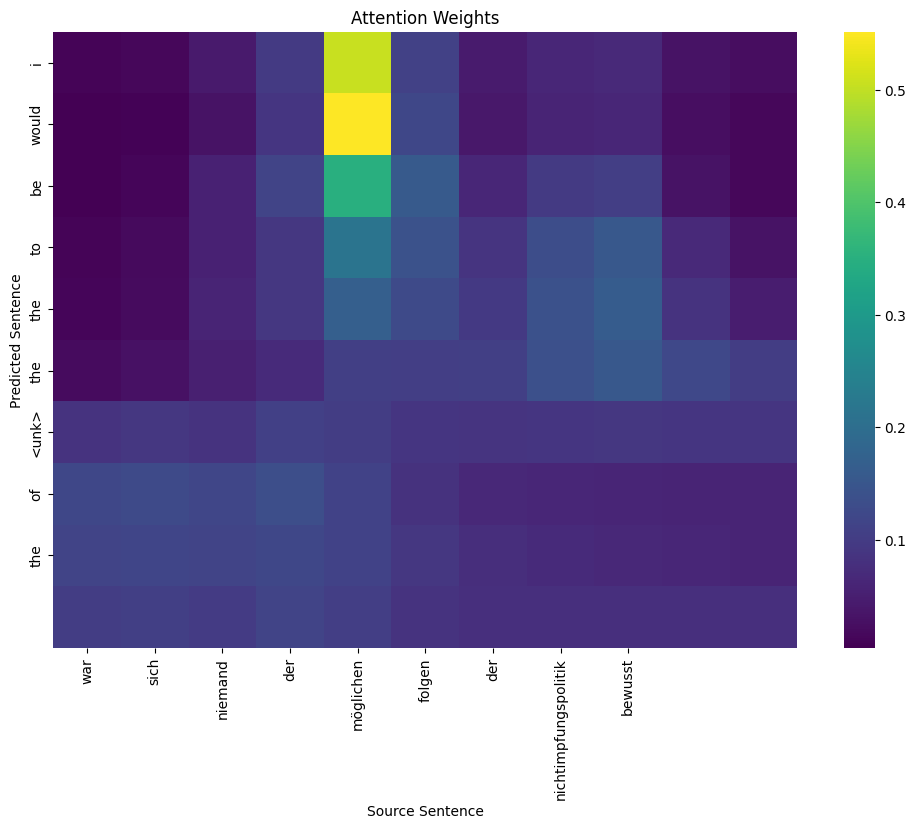

In [37]:
def plot_attention(source_tokens, predicted_tokens, attention_matrix):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(attention_matrix, xticklabels=source_tokens, yticklabels=predicted_tokens, cmap='viridis', ax=ax)
    plt.xlabel('Source Sentence')
    plt.ylabel('Predicted Sentence')
    plt.title('Attention Weights')
    plt.show()

plot_attention(source_tokens, predicted_tokens, attention_matrix)


In [ ]:
# Compute BLEU score for each sentence individually
sentence_lengths = [len(example["de"].split()) for example in test_data]
sentence_bleu_scores = []

for pred, ref in zip(predictions, references):
    score = bleu.compute(predictions=[pred], references=[ref], tokenizer=tokenizer_fn)
    sentence_bleu_scores.append(score["bleu"])

# Analyze the relationship between sentence length and BLEU score
lengths_vs_scores = list(zip(sentence_lengths, sentence_bleu_scores))


# Plot the data
sns.scatterplot(x=sentence_lengths, y=sentence_bleu_scores)
plt.xlabel("Sentence Length")
plt.ylabel("BLEU Score")
plt.title("Sentence Length vs BLEU Score")
plt.show()

# Calculate correlation coefficient
correlation = np.corrcoef(sentence_lengths, sentence_bleu_scores)[0, 1]
print(f"Correlation between sentence length and BLEU score: {correlation}")

In [53]:
# Compute BLEU score for all sentences
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

results

{'bleu': 0.005147737119350844,
 'precisions': [0.18939459118414637,
  0.021412107242508794,
  0.0012549877719140172,
  0.0005820921075158363],
 'brevity_penalty': 0.697753162935185,
 'length_ratio': 0.7353536631658864,
 'translation_length': 34869,
 'reference_length': 47418}

In [54]:
from rouge_score import rouge_scorer

# Adjust the function to ensure `references` is a list of single strings
def compute_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Initialize score counters
    scores = {"rouge1": 0, "rouge2": 0, "rougeL": 0}
    count = len(predictions)
    
    for pred, ref in zip(predictions, references):
        # Score method expects both pred and ref to be single strings
        score = scorer.score(ref, pred)
        for key in scores.keys():
            scores[key] += score[key].fmeasure
    
    # Average scores
    for key in scores.keys():
        scores[key] /= count
    
    return scores

# Prepare predictions and references
# Ensure references are in string format
predictions = [" ".join(translation[0][1:-1]) for translation in translations]
references = [example["en"] for example in test_data]  # Ensure this is a list of strings

# Compute ROUGE scores
rouge_scores = compute_rouge(predictions, references)
print(f"ROUGE scores: {rouge_scores}")

ROUGE scores: {'rouge1': 0.15254624717519408, 'rouge2': 0.015787290554856417, 'rougeL': 0.14346251006697916}


## Load Word2vec embedding Matrices. <br>Train with Word2vec embeddings. <br>Evaluate with Word2vec embeddings.

In [39]:
os.makedirs("embeddings", exist_ok=True)
import gensim

def load_word2vec_embeddings(word2vec_file, vocab, embedding_dim, binary=True):
    # Initialize the embedding matrix with small random values using PyTorch
    embedding_matrix = torch.randn((len(vocab), embedding_dim)) * 0.01
    
    # Get the string-to-index mapping from the vocabulary
    stoi = vocab.get_stoi()
    
    if binary:
        # Load the Word2Vec model from a binary file
        word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_file, binary=True)
        
        # Iterate over each word in the Word2Vec model
        for word in word2vec.key_to_index:
            if word in vocab:  # Check if the word is in the vocabulary
                idx = stoi[word]  # Get the index of the word in the vocabulary
                embedding_matrix[idx] = torch.tensor(word2vec[word])  # Place the embedding at the correct index
    else:
        # Read the embeddings from the text file
        with open(word2vec_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                # Remove the b' and ' from the word part
                word = parts[0][2:-1]
                vector = torch.tensor([float(x) for x in parts[1:]], dtype=torch.float)
                if word in vocab:  # Check if the word is in the vocabulary
                    idx = stoi[word]  # Get the index of the word in the vocabulary
                    embedding_matrix[idx] = vector  # Place the embedding at the correct index


    # Initialize special token embeddings
    # 0: '<unk>', 1: '<pad>', 2: '<sos>', 3: '<eos>'
    embedding_matrix[0] = torch.randn(embedding_dim) * 0.1  # Small random values for unknown
    embedding_matrix[1] = torch.zeros(embedding_dim)  # Zero initialization for padding token
    embedding_matrix[2] = torch.randn(embedding_dim) * 0.1  # Small random values (sos)
    embedding_matrix[3] = torch.randn(embedding_dim) * 0.1  # Small random values (eos)
    
    return torch.FloatTensor(embedding_matrix)

# Example usage
embedding_dim = 300
en_word2vec_file = 'GoogleNews-vectors-negative300.bin'
de_word2vec_file = 'word2vec.de.txt'

# Assuming en_vocab and de_vocab are your vocabularies of type torchtext.vocab.Vocab
# en_wembedding_matrix = load_word2vec_embeddings(en_word2vec_file, en_vocab, embedding_dim, binary=True)
# de_wembedding_matrix = load_word2vec_embeddings(de_word2vec_file, de_vocab, embedding_dim, binary=False)

# Save the embedding matrices
# torch.save(en_wembedding_matrix, 'embeddings/en_wembedding_matrix.pt')
# torch.save(de_wembedding_matrix, 'embeddings/de_wembedding_matrix.pt')

# Load the embedding matrices
en_wembedding_matrix = torch.load("embeddings/en_wembedding_matrix.pt")
de_wembedding_matrix = torch.load("embeddings/de_wembedding_matrix.pt")

### Train with word2vec embeddings

In [56]:
os.makedirs("models", exist_ok=True)
import gc
gc.collect()
torch.cuda.empty_cache()

model = Seq2Seq(encoder, decoder, device).to(device)

# Load our preptrained word2vec embeddings
encoder.embedding.weight.data.copy_(de_wembedding_matrix)
decoder.embedding.weight.data.copy_(en_wembedding_matrix)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5
best_valid_loss = float("inf")

for epoch in range(n_epochs):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "models/word_model_word2vec_de_en_attention.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")
    print(f"Batch {epoch+1} done \n")

100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


	Train Loss:   5.785 | Train PPL: 325.243
	Valid Loss:   5.803 | Valid PPL: 331.208
Batch 1 done 



100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


	Train Loss:   5.494 | Train PPL: 243.213
	Valid Loss:   5.768 | Valid PPL: 319.999
Batch 2 done 



100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


	Train Loss:   5.394 | Train PPL: 220.043
	Valid Loss:   5.755 | Valid PPL: 315.889
Batch 3 done 



100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


	Train Loss:   5.334 | Train PPL: 207.344
	Valid Loss:   5.722 | Valid PPL: 305.525
Batch 4 done 



100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


	Train Loss:   5.263 | Train PPL: 193.019
	Valid Loss:   5.693 | Valid PPL: 296.805
Batch 5 done 



100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


	Train Loss:   5.231 | Train PPL: 187.041
	Valid Loss:   5.684 | Valid PPL: 293.985
Batch 6 done 



100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


	Train Loss:   5.168 | Train PPL: 175.615
	Valid Loss:   5.663 | Valid PPL: 288.149
Batch 7 done 



100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


	Train Loss:   5.117 | Train PPL: 166.892
	Valid Loss:   5.630 | Valid PPL: 278.620
Batch 8 done 



100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


	Train Loss:   5.061 | Train PPL: 157.725
	Valid Loss:   5.654 | Valid PPL: 285.316
Batch 9 done 



100%|██████████| 10/10 [00:02<00:00,  3.83it/s]

	Train Loss:   5.025 | Train PPL: 152.214
	Valid Loss:   5.635 | Valid PPL: 280.002
Batch 10 done 



### Evaluate German to English with BLEU and ROUGH scores with Word2Vec embeddings.

In [41]:
model.load_state_dict(torch.load("models/word_model_word2vec_de_en_attention.pt"))
test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

100%|██████████| 30/30 [00:05<00:00,  5.69it/s]

| Test Loss: 5.598 | Test PPL: 269.800 |


In [42]:
# Load BLEU metric
bleu = evaluate.load("bleu")

# Function to translate sentences from English to German
translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm(test_data)
]

# Format the predictions for BLEU evaluation
predictions = [" ".join(translation[0][1:-1]) for translation in translations]
references = [[example["en"]] for example in test_data]

100%|██████████| 1904/1904 [00:54<00:00, 34.75it/s]


In [43]:
predictions[1], references[1]

('the the of the <unk> of the <unk> of the <unk> of the the of the the of the the',
 ['the rules in question are liable to distort competition and may affect trade between switzerland and the eu'])

In [44]:
# Function to get the tokenizer
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        # Split the text by spaces first to handle special tokens
        tokens = s.split()
        # Process each token using the NLP tokenizer, except for special tokens
        processed_tokens = []
        for token in tokens:
            if token == "<unk>" or "<sos>" or "<eos>":
                processed_tokens.append(token)
            else:
                processed_tokens.extend([tok.text for tok in nlp.tokenizer(token)])
        
        # Convert to lowercase if required
        if lower:
            processed_tokens = [token.lower() for token in processed_tokens]
        return processed_tokens
    return tokenizer_fn

# Get the tokenizer function
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [45]:
source = test_data[2]["de"]

prediction, attention_weights = translate_sentence(
    source,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [46]:
# Tokenize the source and predicted sentences
source_tokens = [token.text for token in en_nlp(source)]
predicted_tokens = prediction[1:-1]

In [47]:
# Squeeze the attention weights to remove the batch dimension
attention_matrix = np.squeeze(attention_weights, axis=1)  # Shape: 

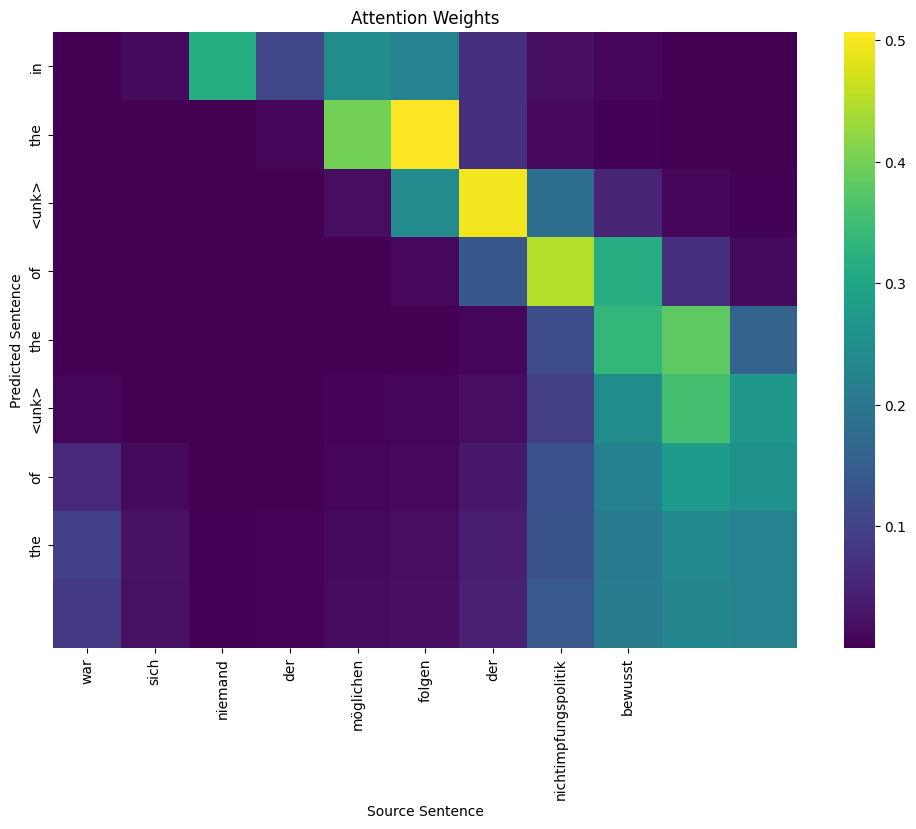

In [48]:
def plot_attention(source_tokens, predicted_tokens, attention_matrix):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(attention_matrix, xticklabels=source_tokens, yticklabels=predicted_tokens, cmap='viridis', ax=ax)
    plt.xlabel('Source Sentence')
    plt.ylabel('Predicted Sentence')
    plt.title('Attention Weights')
    plt.show()
    
# Plot the attention weights
plot_attention(source_tokens, predicted_tokens, attention_matrix)

Top 1 Sentence:
Sentence: mr president ladies and gentlemen the <unk> of the <unk> of the <unk>
BLEU Score: 0.36624839813098803

Top 2 Sentence:
Sentence: mr president ladies and gentlemen i am <unk> to the the the the the of the
BLEU Score: 0.3192029787618873

Top 3 Sentence:
Sentence: mr president ladies and gentlemen i would like to the the the the the the the of the the of the european of the
BLEU Score: 0.25438304218072993



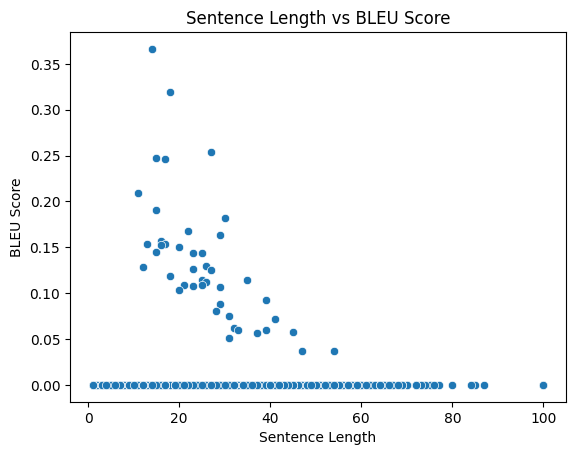

Correlation between sentence length and BLEU score: -0.006152711340156572


In [71]:
# Compute BLEU score for each sentence individually
sentence_lengths = [len(example["de"].split()) for example in test_data]
sentence_bleu_scores = []

for pred, ref in zip(predictions, references):
    score = bleu.compute(predictions=[pred], references=[ref], tokenizer=tokenizer_fn)
    sentence_bleu_scores.append(score["bleu"])

# Pair sentences with their BLEU scores
sentences_with_scores = list(zip(predictions, sentence_bleu_scores))

# Sort sentences by BLEU score in descending order
sorted_sentences = sorted(sentences_with_scores, key=lambda x: x[1], reverse=True)

# Select top 5 sentences
top_sentences = sorted_sentences[:3]

# Display top 5 sentences with their BLEU scores
for idx, (sentence, score) in enumerate(top_sentences, start=1):
    print(f"Top {idx} Sentence:")
    print(f"Sentence: {sentence}")
    print(f"BLEU Score: {score}\n")

# Plotting Sentence Length vs BLEU Score
lengths_vs_scores = list(zip(sentence_lengths, sentence_bleu_scores))
sns.scatterplot(x=[length for length, _ in lengths_vs_scores], y=[score for _, score in lengths_vs_scores])
plt.xlabel("Sentence Length")
plt.ylabel("BLEU Score")
plt.title("Sentence Length vs BLEU Score")
plt.show()

# Calculate correlation coefficient
correlation = np.corrcoef([length for length, _ in lengths_vs_scores], [score for _, score in lengths_vs_scores])[0, 1]
print(f"Correlation between sentence length and BLEU score: {correlation}")

In [67]:
# Compute BLEU score for all sentences
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

results

{'bleu': 0.01173395451868042,
 'precisions': [0.2212152420185376,
  0.03478694554409152,
  0.005466834537141342,
  0.002190038855528082],
 'brevity_penalty': 0.6735031434148796,
 'length_ratio': 0.7167109536462947,
 'translation_length': 33985,
 'reference_length': 47418}

In [68]:
from rouge_score import rouge_scorer

# Adjust the function to ensure `references` is a list of single strings
def compute_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Initialize score counters
    scores = {"rouge1": 0, "rouge2": 0, "rougeL": 0}
    count = len(predictions)
    
    for pred, ref in zip(predictions, references):
        # Score method expects both pred and ref to be single strings
        score = scorer.score(ref, pred)
        for key in scores.keys():
            scores[key] += score[key].fmeasure
    
    # Average scores
    for key in scores.keys():
        scores[key] /= count
    
    return scores

# Prepare predictions and references
# Ensure references are in string format
predictions = [" ".join(translation[0][1:-1]) for translation in translations]
references = [example["en"] for example in test_data]  # Ensure this is a list of strings

# Compute ROUGE scores
rouge_scores = compute_rouge(predictions, references)
print(f"ROUGE scores: {rouge_scores}")

ROUGE scores: {'rouge1': 0.17912887668505809, 'rouge2': 0.028097161293787764, 'rougeL': 0.16348095882931798}
